In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


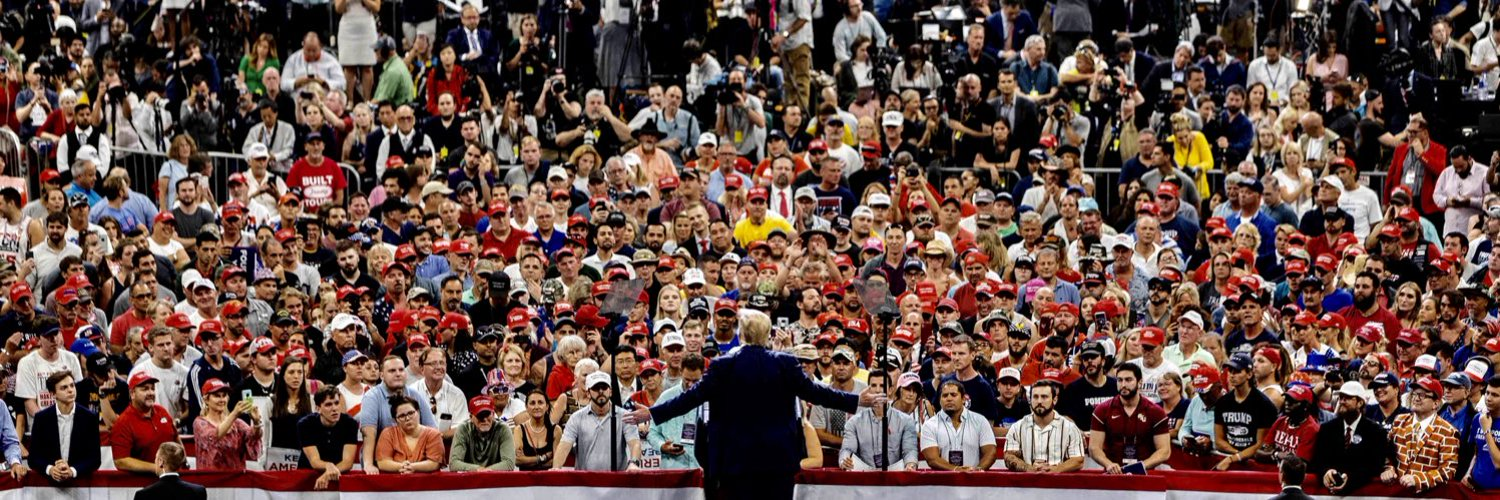

In [2]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/Colab Projects/trump/djt-twitterheader.jpeg') 

Source: [Header photo of Donald Trump's Twitter account](https://twitter.com/realDonaldTrump/header_photo)

## Introduction

Out of all the social media platforms in operation today, Twitter is potentially the best at being able to quickly find out what's happening in the world. A constant stream of once 140, but recently 280-character messages show what people think about sports, entertainment, politics, and more. At least within the context of the U.S.A., Twitter has been used increasingly in the past few years by politicians to give the public an idea of what actually goes on in government --- however opinionated their statements may seem. With that in mind, there is likely no Twitter account followed more closely today than that of our very own 45th President, Donald Trump. 

Trump's timeline provides for a relatively public view of how he aims to run the country and convey the office of the presidency --- as it should. Regardless of what he says (good or bad), CNN, Fox News, the Washington Post, and other news organizations spend considerable effort giving his tweets attention and debating the resulting impact on the country. It is no secret that President Trump is a Republican and wastes no time speaking out against celebrities, congressmen, senators, governors, aspiring candidates, and others on the other side of political aisle. It is also fairly obvious to see that President Trump's tweets grab headlines and that he rushes to defend himself on the platform in the face of questionable decisions or damaging legal investigations.

This notebook will attempt to go through the entirety of Donald Trump's Twitter timeline and provide insights into how he uses the platform. At the end, just for fun, there will also be a generator that uses a pre-trained language model to construct new tweets of Trump's likeness.   

## Cleanup & First Insights

In [3]:
import pandas as pd
import numpy as np
import os
import time 
import re
from datetime import datetime

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import cufflinks as cf

pd.set_option('display.max_colwidth', -1)
pio.renderers.default = 'colab'
cf.go_offline()

windows_path = '/Users/Aniruddha/Desktop/projects/trump/djt-06032020.csv'
mac_path = '/Users/aniruddhaprabhu/Library/Mobile Documents/com~apple~CloudDocs/Data/trump/csv/djt-06032020.csv'
gdrive_path = '/content/drive/My Drive/Colab Projects/trump/csv/djt-11072020.csv'

tweets = pd.read_csv(gdrive_path)

# tweets[tweets['created_at'] == '13']
# tweets[34790:34795]
# tweets.drop([34645, 34646, 34769, 34770, 34794,34795], inplace=True)

tweets.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,"71,000,000 Legal Votes. The most EVER for a sitting President!",Sat Nov 07 21:54:48 +0000 2020,112219,614411,False,1325195021339987969
1,Twitter for iPhone,"THE OBSERVERS WERE NOT ALLOWED INTO THE COUNTING ROOMS. I WON THE ELECTION, GOT 71,000,000 LEGAL VOTES. BAD THINGS HAPPENED WHICH OUR OBSERVERS WERE NOT ALLOWED TO SEE. NEVER HAPPENED BEFORE. MILLIONS OF MAIL-IN BALLOTS WERE SENT TO PEOPLE WHO NEVER ASKED FOR THEM!",Sat Nov 07 21:53:34 +0000 2020,92429,457831,False,1325194709443080192
2,Twitter for iPhone,"I WON THIS ELECTION, BY A LOT!",Sat Nov 07 15:36:36 +0000 2020,175473,1051231,False,1325099845045071873
3,Twitter for iPhone,Georgia Counties Using Same Software as Michigan Counties Also Encounter ‘Glitch’ https://t.co/N2KlEOezGi via @BreitbartNews What a total mess this “election” has been!,Sat Nov 07 15:23:00 +0000 2020,68638,251205,False,1325096422799237120
4,Twitter for iPhone,"Lawyer’s Press Conference at Four Season’s Landscaping, Philadelphia. Enjoy!",Sat Nov 07 15:00:27 +0000 2020,6191,25293,False,1325090748035985409


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41610 entries, 0 to 41609
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source          41610 non-null  object
 1   text            41610 non-null  object
 2   created_at      41610 non-null  object
 3   retweet_count   41610 non-null  int64 
 4   favorite_count  41610 non-null  int64 
 5   is_retweet      41552 non-null  object
 6   id_str          41610 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.2+ MB


In [5]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format = '%a %b %d %H:%M:%S %z %Y')
tweets['created_at'].head()

0   2020-11-07 21:54:48+00:00
1   2020-11-07 21:53:34+00:00
2   2020-11-07 15:36:36+00:00
3   2020-11-07 15:23:00+00:00
4   2020-11-07 15:00:27+00:00
Name: created_at, dtype: datetime64[ns, UTC]

The times indicated above are from UTC+0000/Greenwich Median Time/U.K Time. Since Donald Trump resides in the White House and conducts his business around D.C./New York/Florida, it is best to convert those times to Eastern Standard Time/UTC-0500 as a frame of reference for when he tweets.

In [6]:
# tweets['created_at'] = tweets['created_at'].dt.tz_localize('UTC')
tweets['created_at'] = tweets['created_at'].dt.tz_convert('US/Eastern')
tweets['created_at'].head()

0   2020-11-07 16:54:48-05:00
1   2020-11-07 16:53:34-05:00
2   2020-11-07 10:36:36-05:00
3   2020-11-07 10:23:00-05:00
4   2020-11-07 10:00:27-05:00
Name: created_at, dtype: datetime64[ns, US/Eastern]

Since this notebook aims to examine tweets themselves and not the content of any external sources, the URLs need to be removed from the text. For instance, Mr. Trump occasionally makes tweets that include direct links to external media or tweets from other accounts, which are irrelevent to what he actually types out. Additionally, some of his tweets include only the links & nothing else, so those tweets need to be deleted entirely from the dataframe.  

In [7]:
for index, row in tweets.iterrows():
    tweets['text'][index] = ' '.join([word for word in tweets['text'][index].split() if 'http' not in word])
    
tweets.drop(tweets[tweets['text'] == ''].index, inplace=True)
len(tweets)

40490

In [8]:
mtweet_starting = tweets[tweets['text'].str.endswith('..') & ~(tweets['text'].str.startswith('..'))].index
mtweet_middle = tweets[tweets['text'].str.startswith('..') & tweets['text'].str.endswith('..')].index
mtweet_ending = tweets[tweets['text'].str.startswith('..') & ~(tweets['text'].str.endswith('..'))].index

tweets.drop(mtweet_starting, inplace=True)
tweets.drop(mtweet_middle, inplace=True)
tweets.drop(mtweet_ending, inplace=True)
len(tweets)

37467

In [9]:
tweets = tweets[~tweets['text'].str.startswith('RT')]
len(tweets)

30766

## Tweet Statistics

In [10]:
sources = tweets['source'].value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Pie(labels=sources.index.values, values=sources['source'])])
fig.update_layout(
    title_text="Tweet Sources for Donald Trump")
fig.show()

In [11]:
days = tweets['created_at'].dt.day_name().value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Bar(x=days.index.values, y=days['created_at'])])
fig.update_layout(
    title_text="Weekly Tweet Distribution of Donald Trump", 
    xaxis=dict(title='Day of Week'),
    yaxis=dict(title='Number of Tweets'))
fig.show()

It's pretty obvious to see here that Mr. Trump tweets pretty evenly on the weekdays, but tends to cut down on the weekends. Now on to the time of day...

In [12]:
hour_of_days = tweets['created_at'].dt.hour.value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Bar(x=hour_of_days.index.values, y=hour_of_days['created_at'])])
fig.update_layout(
    title_text="Intra-day Tweet Distribution of Donald Trump", 
    xaxis=dict(title='Hour of Day (24-HR time)'),
    yaxis=dict(title='Number of Tweets'))
fig.show()

In [13]:
tweets['total_engagements'] = tweets['retweet_count'] + tweets['favorite_count'].astype(float)
largest = tweets.nlargest(10, 'total_engagements')[['text','created_at', 'total_engagements']]

for index, row in largest.iterrows():
    print('Text:', row['text'] + '\n' + 
          'Created At:', str(row['created_at']) + '\n' +
          'Total Engagements:', row['total_engagements'], '\n')

Text: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!
Created At: 2020-10-02 00:54:06-04:00
Total Engagements: 2299293.0 

Text: Going welI, I think! Thank you to all. LOVE!!!
Created At: 2020-10-02 23:31:34-04:00
Total Engagements: 1366176.0 

Text: I WON THIS ELECTION, BY A LOT!
Created At: 2020-11-07 10:36:36-05:00
Total Engagements: 1226704.0 

Text: A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!
Created At: 2019-08-02 13:41:30-04:00
Total Engagements: 1131177.0 

Text: VOTE! VOTE! VOTE!
Created At: 2020-11-03 02:57:08-05:00
Total Engagements: 1075019.0 

Text: WE ARE LOOKING REALLY GOOD ALL OVER THE COUNTRY. THANK YOU!
Created At: 2020-11-03 18:15:55-05:00
Total Engagements: 1070638.0 

Text: I will be making a statement tonight. A big WIN!
Created At: 2020-11-04 00:45:53-05:00
Total Engagements: 1061

## Content Analysis

The next section of this notebook will attempt to quantify this by looking deeper into the content of the tweets. This would include areas such as how much Donald Trump tweets about something and his perception of it (positive or negative).

In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('vader_lexicon')

import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sw = set(stopwords.words('english'))
sid = SentimentIntensityAnalyzer()

def clean_tweet(txt):
    txt = txt.lower()
    txt = [word.strip(string.punctuation) for word in txt.split(' ')]
    txt = ' '.join(txt)
    
    return txt

def get_sentiment(poly):
    if poly >= 0.05:
        return 'positive'
    elif poly <= -0.05: 
        return 'negative' 
    elif poly > -0.05 and poly < 0.05:
        return 'neutral'

tweets['text_clean'] = tweets['text'].apply(lambda tweet: clean_tweet(tweet))
tweets['polarity'] = tweets['text'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])
tweets['sentiment'] = tweets['polarity'].apply(lambda polarity: get_sentiment(polarity))

obama_tweets = tweets[tweets['text_clean'].str.contains('obama')]
obama_tweets.head()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,total_engagements,text_clean,polarity,sentiment
104,Twitter for iPhone,"I gave Maine everything that Obama/Biden took away from it. 5000 square miles, Lobster, Fishing, ended tariffs from China and E.U. and much more. Vote Trump Maine!",2020-11-02 14:29:20-05:00,19401,103644,False,1323346474348896256,123045.0,i gave maine everything that obama/biden took away from it 5000 square miles lobster fishing ended tariffs from china and e.u and much more vote trump maine,0.0000,neutral
217,Twitter for iPhone,"Biden &amp; Obama owe a massive apology to the People of Flint. The water was poisoned on their watch. Not only did they fail them, Biden proudly accepted the endorsement of disastrous Gov Rick Snyder! Unlike Biden, I will always stand with the People of the Great State of MICHIGAN!",2020-10-31 15:07:38-04:00,36734,164845,False,1322616235423539200,201579.0,biden amp obama owe a massive apology to the people of flint the water was poisoned on their watch not only did they fail them biden proudly accepted the endorsement of disastrous gov rick snyder unlike biden i will always stand with the people of the great state of michigan,0.3147,positive
225,Twitter for iPhone,"Gallup: 56% of the U.S. is more satisfied with conditions now, even during a pandemic (we are rounding the turn!), than they were 4 years ago under Obama/Biden. Hasn’t been equaled in recent times!",2020-10-31 11:22:02-04:00,22013,112620,False,1322559460821270529,134633.0,gallup 56 of the u.s is more satisfied with conditions now even during a pandemic we are rounding the turn than they were 4 years ago under obama/biden hasn’t been equaled in recent times,0.5686,positive
250,Twitter for iPhone,"“President Obama meant a lot to Black people, but he didn’t do a thing for Black people”. Vernon Jones, Georgia State Represenative, Trump supporter. @ffweekend",2020-10-31 08:25:20-04:00,23520,112939,False,1322514994320297986,136459.0,“president obama meant a lot to black people but he didn’t do a thing for black people” vernon jones georgia state represenative trump supporter ffweekend,0.3919,positive
263,Twitter for iPhone,"President Obama used to say that “if you wanted to see something really screwed up, give it to Joe Biden to do.” In fact, he tried to keep Joe from running, “you don’t have to do this Joe”, and then wouldn’t endorse him until long after the Primaries ended. “Joe is lost!”.",2020-10-30 19:51:21-04:00,31731,148646,False,1322325248927150082,180377.0,president obama used to say that “if you wanted to see something really screwed up give it to joe biden to do.” in fact he tried to keep joe from running “you don’t have to do this joe” and then wouldn’t endorse him until long after the primaries ended “joe is lost!”,-0.3580,negative


In [15]:
sentiments = obama_tweets['sentiment'].value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Pie(labels=sentiments.index.values, values=sentiments['sentiment'])])
fig.update_layout(
    title_text="Sentiment of Trump's Tweets mentioning Obama")
fig.show()

The tweets that mention former president Barack Obama appear to be positive 34.8% of the time --- an odd figure given Trump's public opinion of him. However, there is a noticeable plurality of negative sentiment.

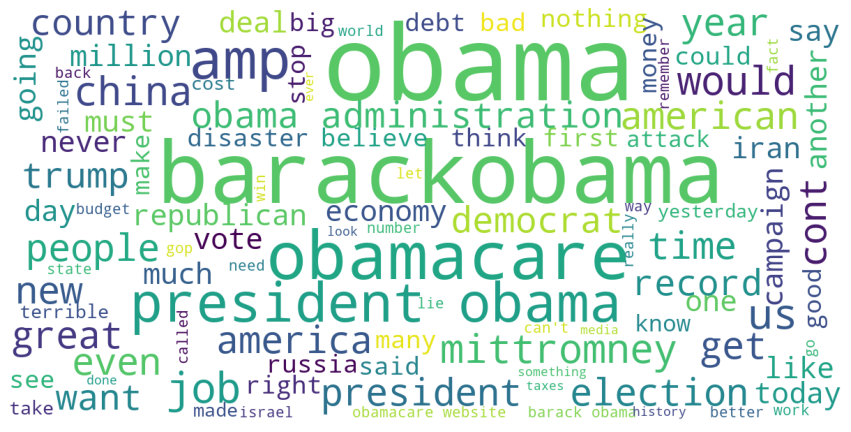

In [16]:
def show_wordcloud(data, column):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 50, 
        scale = 3,
        random_state = 42, 
        stopwords = sw
    ).generate(" ".join([i for i in data[column]]))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(obama_tweets, 'text_clean')

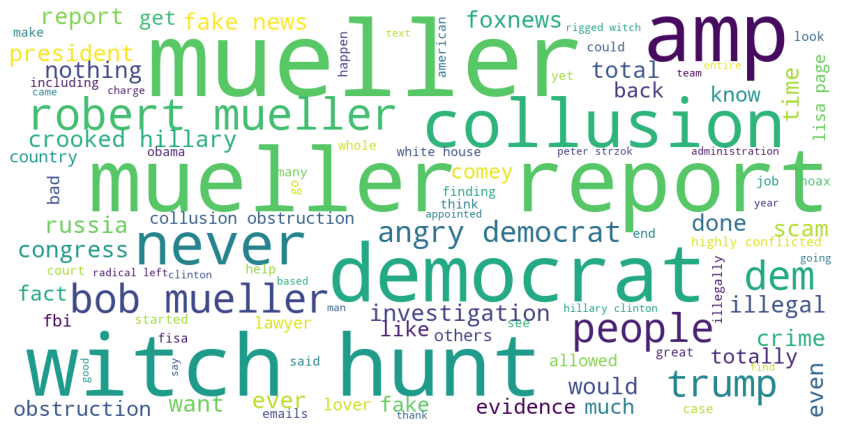

In [17]:
mueller_tweets = tweets[tweets['text_clean'].str.contains('mueller')]
show_wordcloud(mueller_tweets, 'text_clean')

As expected, the phrases 'witch hunt' and 'collusion' are fairly large here since these are Trump's go-to attacks on the Robert Mueller's investigation into both his & Russia's involvement in the 2016 election.

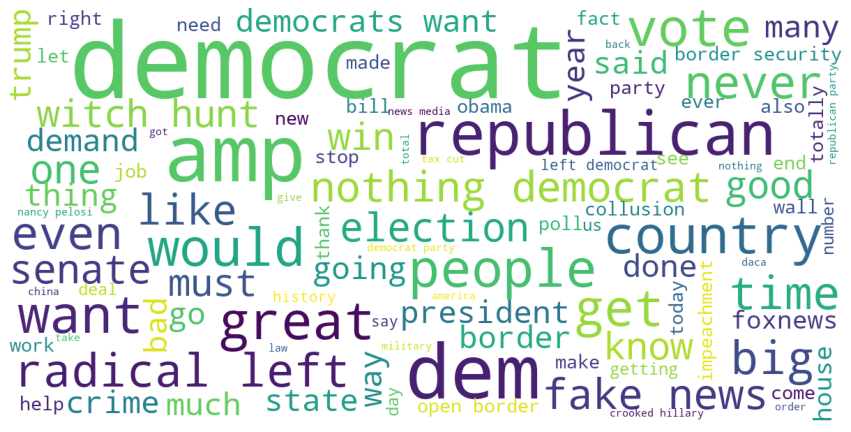

In [18]:
dem_tweets = tweets[tweets['text_clean'].str.contains('dem')]
show_wordcloud(dem_tweets, 'text_clean')

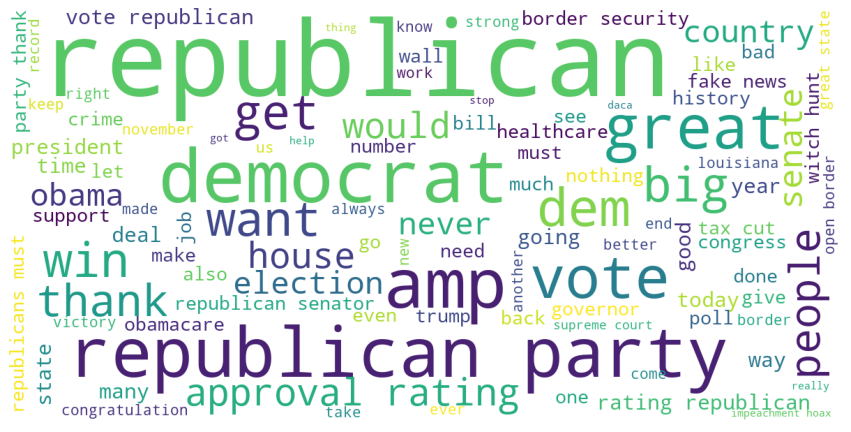

In [19]:
gop_tweets = tweets[tweets['text_clean'].str.contains('republican')]
show_wordcloud(gop_tweets, 'text_clean')

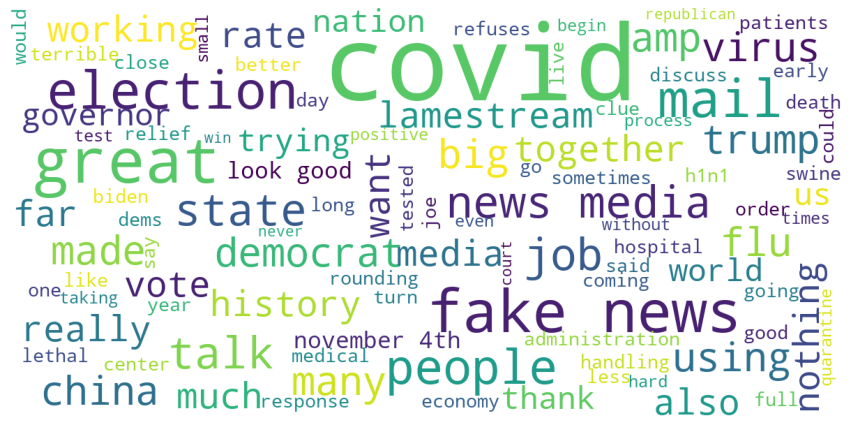

In [20]:
covid_tweets = tweets[tweets['text_clean'].str.contains('covid')]
show_wordcloud(covid_tweets, 'text_clean')

## Just for Fun: Tweet Generator

### FastAI LSTM

In [21]:
from fastai import *
from fastai.text import *
from sklearn.model_selection import train_test_split

train_tweets, test_tweets = train_test_split(tweets, test_size=0.1, random_state=7)
mac_models_path = '/Users/aniruddhaprabhu/Desktop/Data/trump'
colab_models_path = ''

lmdb = TextLMDataBunch.from_df(path=colab_models_path, train_df=train_tweets, valid_df=test_tweets, text_cols='text')
lml = language_model_learner(data=lmdb, arch=AWD_LSTM, pretrained=True, drop_mult=0.5)

In [22]:
lml.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


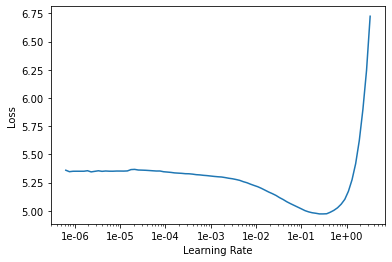

In [23]:
lml.recorder.plot()

In [24]:
lml.fit(epochs=10, lr=5e-2, wd=1e-8)

epoch,train_loss,valid_loss,accuracy,time
0,4.299288,3.895960,0.314148,01:12
1,3.985868,3.825623,0.322173,01:12
2,3.860775,3.802427,0.327594,01:12
3,3.782356,3.822468,0.330145,01:12
4,3.726571,3.825433,0.327817,01:12
5,3.690029,3.827700,0.331580,01:12
6,3.665353,3.830201,0.333790,01:12
7,3.649834,3.838854,0.333705,01:12
8,3.625103,3.850850,0.332621,01:13
9,3.628768,3.872337,0.332653,01:13


In [25]:
generated_tweets = []

for twt in range(30):
    sample = lml.predict(text='', n_words=30, temperature=0.7)
    sample_cleaned = [sentence for sentence in sample.split('xxbos') if sentence not in ['', ' ']]
    generated_tweets.append(sample_cleaned[0])
    
generated_tweets

[' The Democrats are getting a big part of the World Trade Deal with our Country , and neither should be the Democrats .',
 ' So Congressman Scott Walker ( and myself ) should be named on the Republican Party ( maybe the Democrats ) . He',
 ' Congratulations to @judicialwatch for receiving his great economist , Sidney ',
 ' Thank you Steve Hilton Head . He was very proud of your very strong leaders . He was a great guy , he was',
 ' Thank you Jacksonville ! ',
 ' Glad to hear @ewerickson of the Trump Tower atrium was great . ',
 ' Via @worldnetdaily by Eugene Dunn : “ Donald Trump : Donald Trump : Donald J. Trump Proclaims Feb.',
 ' Thank you North Carolina ! # makeamericagreatagain # Trump2016 ',
 ' Via @lasvegassun by Eugene R. Dunn : “ Donald J. Trump ” ',
 ' Thank you Joey ',
 ' The American People , just named Bernie Sanders . They have not been treated fairly . He was the only one who understands',
 ' Via me by @AP : “ Donald Trump was No Obstruction of the American Worker ” ',
 

In [26]:
num_words = 0

for t in tweets['text_clean']:
    num_words += len(t.split(' '))
    
num_words / len(tweets)

19.83094974972372

In [27]:
lml.predict(text='Obama', n_words=30, temperature=0.5)

"Obama ’s only time with Iran 's nuclear drive . He was a great builder -- he is a disaster . xxbos Thank you Kansas ! xxbos"

### GPT-2 Medium (345M parameters)

In [28]:
!git clone https://github.com/openai/gpt-2.git

Cloning into 'gpt-2'...
remote: Enumerating objects: 230, done.
remote: Total 230 (delta 0), reused 0 (delta 0), pack-reused 230
Receiving objects: 100% (230/230), 4.38 MiB | 1.14 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [29]:
%cd gpt-2/
!pip install tensorflow-gpu==1.15
!pip install -r requirements.txt
!python3 "/content/gpt-2/download_model.py" 345M

/content/gpt-2
     |████████████████████████████████| 411.5MB 41kB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 3.8MB 41.0MB/s 
     |████████████████████████████████| 512kB 40.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=a74f9e832b49f1e7db9f19a6ca3b0c68f82233ee910a5612793979308fff92fb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  F

Fetching checkpoint: 1.00kit [00:00, 746kit/s]                                                      
Fetching encoder.json: 1.04Mit [00:00, 1.31Mit/s]                                                   
Fetching hparams.json: 1.00kit [00:00, 717kit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:33, 42.8Mit/s]                                 
Fetching model.ckpt.index: 11.0kit [00:00, 7.78Mit/s]                                               
Fetching model.ckpt.meta: 927kit [00:00, 38.0Mit/s]                                                 
Fetching vocab.bpe: 457kit [00:00, 32.8Mit/s]                                                       


In [30]:
# Code to generate corpus of Trump tweets if needed to a text file, filters out retweets.
# ---This step already completed in the tweets dataframe during cleanup step earlier in the notebook.
#
# djt_corpus = tweets[~tweets['text'].str.startswith('RT')]['text']
# pd.set_option('display.max_colwidth', -1)

# for t in (('Tweet: ' + djt_corpus[:10000])[::-1]): 
#     textfile = open('djtcorpus_06032020.txt', 'a')
#     textfile.write(t + '\n')
#     textfile.close()
#     print(t)

In [31]:
# Modify the interactive samples script in gpt-2/script by making a variable to store some of the text column from the tweets dataframe 
# and feed this to the tokenizer at the end. Also remove the for loops at the end and tune parameters to your liking. 
# Then run the script as below to generate some samples. 
!python3 "/content/gpt-2/src/gpt2_samples_script.py"

python3: can't open file '/content/gpt-2/src/gpt2_samples_script.py': [Errno 2] No such file or directory


## Concluding Thoughts
From just the provided data, it was fairly easy to get an idea of Trump's general tweeting behavior. As expected, President Trump feels negatively towards subjects that involve Democrats and positive towards subjects that involve the GOP/Republicans. Despite the language model only giving a baseline accuracy of just over 30%, the resulting generated tweets do in fact seem like something that Trump would put out, grammar and punctuation mistakes notwithstanding.

For further investigation, it would have been nice to have data regarding the number of replies/comments to his tweets. Even though he rarely goes back-and-forth with other users on the platform, this could give a better understanding of how many people interact with him. Additionally, a dataset of Trump's follower counts would help get a sense of his popularity over time and match growth spikes to various news-worthy events.